<h1 style="text-align: center;" markdown="3">Machine Learning 1: Logistic Regression Classifier</h1> 

# Table of Contents
[Introduction](#introduction)        
[Logistic Regression simple Model](#simple-model)           
&nbsp;&nbsp;&nbsp;[Class Weighting](#class-weighting)  
&nbsp;&nbsp;&nbsp;[Oversampling and Undersampling](#over-and-under-sampling)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Undersampling](#undersampling)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Oversampling](#oversampling)  
[Cross Validation and Parameter Tuning](#cv-and-param-tuning)  
[Feature Selection](#feature-selection)  
[Logistic Regression Summary](#summary)

# Introduction <a class="anchor" id="introduction"></a>

The first classifier we introduce in this series is the logistic regression classifier. Logistic regression is one of the most simple and well-known machine learning algorithms for binary classification.

## Consideration
There are a few things to remember when using logistic regression as a classifier. First, it assumes that there is a linear relationship between the independent variables and the dependent variables. In high-dimensional datasets, this may not be the case, so logistic regression may not be the best choice of classifier.

Logisitic regression is also sensitive to highly correlated inputs. Having highly correlated inputs can cause the model to be overfit or will cause the model to fail to converge. The features elimination with the variance inflation factor we did during the preparation help to deal with this issue.

## Data setup

First, we'll load all the libraries and the data that will be used throughout this notebook. 

In [2]:
# Data importation and manipulation tools
import numpy as np
import pandas as pd
import itertools

# Data visualization tools
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set()

# Machine Learning tools
from sklearn.linear_model import LogisticRegression

# Metrics
from sklearn.metrics import (
    confusion_matrix,
    log_loss,
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    cohen_kappa_score,
    roc_curve,
    auc
)

In [3]:
# load training data 
lcs_train = pd.read_pickle("Data/processed/train.pkl")

# Separate features
X_train = lcs_train.drop(['Persns_wgt', 'sick'], axis=1)
y_train = lcs_train['sick']
w_train = lcs_train['Persns_wgt']

# summarize loaded data
print('Data has {:,} rows and {:,} columns' \
        .format(*X_train.shape))

print('Percent sick: {:0.1%} \tPercent non-sick: {:0.1%}' \
        .format(*y_train.value_counts(normalize=True, ascending=True)))

# print first 5 rows of data
X_train.head()

Data has 39,075 rows and 236 columns
Percent sick: 15.9% 	Percent non-sick: 84.1%


,Q14AGE,Q613BED,Q615KITCHEN,Q616BATH,Q617TOILET,Q161APUBATT,Q161APRIVATT,hhsize,expenditure_pcp,pcnetincome,...,Q221DHEALTH__More than adequate,Q224ANOMONEY__Yes,Q224BNOMONEY5__Yes,Q225ASIZE__Yes,Q225BSIZE5__Yes,Q226ASKIP__Yes,Q226BSKIP5__Yes,Q227ALESS__Yes,Q227BLESS5__Yes,SexOfHead__Male
UQNO,,,,,,,,,,,,,,,,,,,,,
920002240000007301,48,2,0,0,0,0,0,5,3664.148804,400,...,0,0,0,0,0,0,0,0,0,1
417000450000011901,27,0,0,0,0,0,0,4,11451.292500,1250,...,0,0,0,0,0,1,0,1,0,1
107002150000030901,3,1,1,0,0,3,0,6,6066.745258,1000,...,0,1,0,1,0,1,0,1,0,1
919005240000017601,0,1,1,1,0,0,0,3,28007.446415,2620,...,0,0,0,0,0,0,0,0,0,1
983000120000022201,4,3,1,0,0,0,0,7,1727.626033,285,...,0,0,0,0,0,0,0,0,0,0


## Standardization

To standardize the data, we could use the sklearn `standardScaler`'s fonction as we did in the data preparation notebook. The problem is that I would like to keep the column names to better understand what is going on. That's why I created my own standardization function.

In [4]:
# Standardize features
def standardize(df):
    cols = df.loc[:, df.dtypes != 'uint8'].columns
    for field in cols:
        mean, std = df[field].mean(), df[field].std()
        # account for constant columns
        if np.all(df[field] - mean != 0):
            df.loc[:, field] = (df[field] - mean) / std
    
    return df

standardize(X_train)
X_train.head()

,Q14AGE,Q613BED,Q615KITCHEN,Q616BATH,Q617TOILET,Q161APUBATT,Q161APRIVATT,hhsize,expenditure_pcp,pcnetincome,...,Q221DHEALTH__More than adequate,Q224ANOMONEY__Yes,Q224BNOMONEY5__Yes,Q225ASIZE__Yes,Q225BSIZE5__Yes,Q226ASKIP__Yes,Q226BSKIP5__Yes,Q227ALESS__Yes,Q227BLESS5__Yes,SexOfHead__Male
UQNO,,,,,,,,,,,,,,,,,,,,,
920002240000007301,0.955936,-0.414011,-1.395383,-0.582252,-0.528091,-0.298658,-0.286177,-0.157885,-0.431979,-0.283026,...,0,0,0,0,0,0,0,0,0,1
417000450000011901,-0.052461,-1.779027,-1.395383,-0.582252,-0.528091,-0.298658,-0.286177,-0.489928,-0.258849,-0.141051,...,0,0,0,0,0,1,0,1,0,1
107002150000030901,-1.204916,-1.096519,0.262655,-0.582252,-0.528091,1.359649,-0.286177,0.174158,-0.378563,-0.182809,...,0,1,0,1,0,1,0,1,0,1
919005240000017601,-1.348973,-1.096519,0.262655,0.617089,-0.528091,-0.298658,-0.286177,-0.821970,0.109240,0.087779,...,0,0,0,0,0,0,0,0,0,1
983000120000022201,-1.156897,0.268497,0.262655,-0.582252,-0.528091,-0.298658,-0.286177,0.506200,-0.475034,-0.302234,...,0,0,0,0,0,0,0,0,0,0


# Logistic Regression Simple Model <a class="anchor" id="simple-model"></a>
## Fit the Model 

Scikit-Learn's [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) model incorporates several different methods behind the scenes that help it to perform more reliably with different types of datasets:
* It incorporates a regularization function by default. This helps prevent possible overfitting of the data by penalizing large coefficients. This also helps reduce the issues normally would be caused by multicollinearity.
* It lets us keep the categorical labels for the dependent variable. 
* It allows us to incorporate sample weights. In the case of health prediction, utilizing the sample weights in our model allows us to extrapolate the results to the entire population of South Africa.


## Include Sample Weights
We will also include the sample weights that were provided with the dataset. This will allow us to extrapolate the results of our model to the entire population of South Africa and give an estimated sick rate.

The `%time` is called a magic command and it is part of IPython. It gives us the time needed to run the line, which could be helpful when fitting a model is computationally heavy.

In [5]:
# Fit the model
model = LogisticRegression()
%time model.fit(X_train, y_train, sample_weight=w_train)


# Get an initial score
%time score = model.score(X_train, y_train, sample_weight=w_train)
print("In-sample score: {:0.2%}".format(score))

/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


CPU times: user 1.11 s, sys: 50.6 ms, total: 1.16 s
Wall time: 1.17 s
CPU times: user 30 ms, sys: 23.8 ms, total: 53.8 ms
Wall time: 14.3 ms
In-sample score: 89.79%


We can see that the model converged and had calculated coefficients for each variable. One thing to note is the sign of each coefficent. A positive coefficient means that feature pushes the result towards the "sick" category, while negative coefficient pushes the result towards the "healthy" category. Another thing to note is that the logistic regression classifier model does not directly give feature importances, but we can get a basic feel for these by taking the magnitude of each coefficient times the standard deviation of the corresponding feature ([more information here](https://stackoverflow.com/questions/34052115/how-to-find-the-importance-of-the-features-for-a-logistic-regression-model)). Let's try to show those coefficients:

In [6]:
# Extract the coefficient of the model and sort in a DataFrame
def get_coefs_df(X, coefs, sort=True):
    coefs_df = pd.DataFrame(np.std(X, 0) * coefs)
    coefs_df.columns = ["coef_std"]
    coefs_df['coef'] = coefs
    coefs_df['abs'] = coefs_df.coef_std.apply(abs)
    if sort:
        coefs_df = coefs_df.sort_values('abs', ascending=False)
    return coefs_df

In [7]:
# Store coefficients
coefs = get_coefs_df(X_train, model.coef_[0])
coefs.head()

,coef_std,coef,abs
Q14AGE,0.609898,0.609906,0.609898
Q25121HIBLOOD__Yes,0.354206,1.224125,0.354206
Q25125ASTHMA__Yes,0.293733,2.236593,0.293733
Q25111MEDSER__Yes,0.289339,0.861128,0.289339
Q251211AIDS__Yes,0.252955,1.746135,0.252955


Unsurprisingly, The age of an individual seem to play a significant role in predicting health.

## Model evaluation

Now let's see how this model performs on our test set. We first have to load the data and apply the same considerations to the features as we did with the training set.

In [8]:
# Load and transform the test set
lcs_test = pd.read_pickle("Data/processed/test.pkl")

# Separate features
X_test = lcs_test.drop(['Persns_wgt', 'sick'], axis=1)
y_test = lcs_test['sick']
y_test = np.ravel(y_test)
w_test = lcs_test['Persns_wgt']

# Standardize the features
standardize(X_test)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print(y_pred[:10])
print(y_prob[:10])

[False False False False False False False False False False]
[0.04393008 0.08190396 0.15683737 0.02811638 0.03046862 0.01987692
 0.01482219 0.04656756 0.17878115 0.01890346]


The output of the model gives us the probability for each row that it is in the "sick" class, as well as the label with a threshold probability of 0.5.

### Evaluate with metrics
As for the baseline model, let's create our metrics functions.

In [9]:
# Create the ROC plot function
def plot_roc(y_test, y_pred, y_prob, model, ax, sample_weights=None):
    
    # dictionnary of metrics to calculate
    fpr, tpr, _ = roc_curve(y_test, y_prob, sample_weight=sample_weights)
    metrics = {}
    metrics['fpr'] = fpr
    metrics['tpr'] = tpr
    metrics['roc_auc'] = roc_auc_score(y_test,y_prob, sample_weight=sample_weights)
    
    # Create graph with Legend
    ax= ax
    ax.plot(metrics['fpr'], metrics['tpr'], label='{} AUC = {:0.2f}'.format(model, metrics['roc_auc']))
    
    # Specification of Graph
    ax.set_title('Receiver Operating Characteristic')
    ax.plot([0,1],[0,1],'k--')
    ax.set_xlim([-0.01,1])
    ax.set_ylim([0,1.01])
    ax.legend(loc='lower right')
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    return

# Create the confusion matrix plot function
# Derived from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(y_test, y_pred,ax, sample_weight = None):
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred, sample_weight=None)
    # Reverse the results
    cm = cm[::-1,::-1]

    # Create plot
    ax = ax
    tick_marks = np.arange(2)
    ax.set_title('Confusion matrix')
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(["sick", "non-sick"])
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(["sick","non-sick"])
    ax.grid(False)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

    # Create font and color bar
    im = ax.imshow(cm, interpolation='nearest', cmap= plt.cm.Blues)
    fig.colorbar(im, ax=ax, shrink=0.7)

    # Create normalized and text results
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        txt = "{:.0f}".format(cm[i,j])
        txt = txt + "\n{:0.1%}".format(cm_norm[i,j])
        ax.text(j, i, txt, fontsize=14, fontweight='bold',
                     horizontalalignment="center", verticalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    return


# Create a DataFrame to store de model results
model_score = pd.DataFrame(index = ['accuracy','recall','precision','f1','roc_auc','cross_entropy','cohen_kappa'])

# Define a function to show metrics in a DataFrame
def get_metrics(y_test, y_pred, model_name, sample_weights=None): 
    # Show metrics values
    model_scores = {}

    model_scores['accuracy']          = accuracy_score(y_test, y_pred, sample_weight=sample_weights)
    model_scores['recall']            = recall_score(y_test, y_pred, sample_weight=sample_weights)
    model_scores['precision']         = precision_score(y_test, y_pred, sample_weight=sample_weights)
    model_scores['f1']                = f1_score(y_test, y_pred, sample_weight=sample_weights)
    model_scores['roc_auc']           = roc_auc_score(y_test,y_prob, sample_weight=sample_weights)
    model_scores['cross_entropy']     = log_loss(y_test,y_prob,sample_weight=sample_weights)
    model_scores['cohen_kappa']       = cohen_kappa_score(y_test, y_pred)

    print("Model Scores")
    print("Actual sick rate: {:0.2%}".format(y_test.sum()/len(y_test)))
    print("Predicted sick rate: {:0.2%}".format(y_pred.sum()/len(y_pred)))
    model_score[model_name] = model_score.index.map(model_scores)
    return model_score

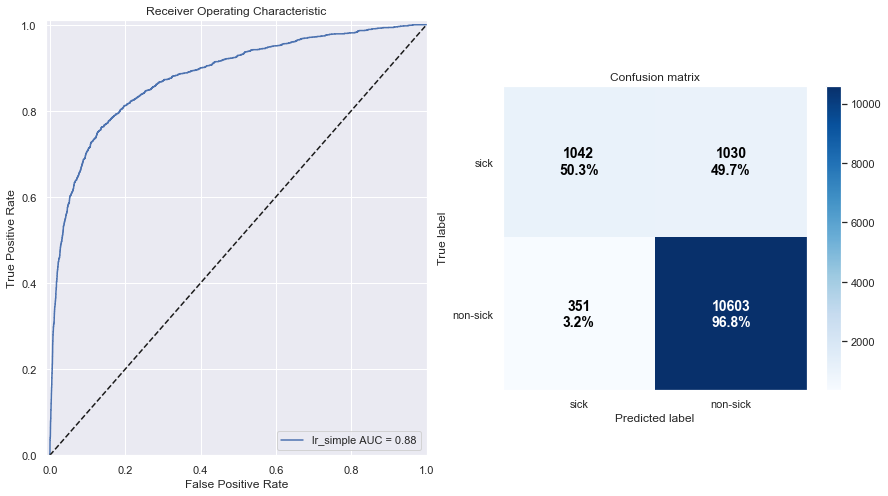

Model Scores
Actual sick rate: 15.91%
Predicted sick rate: 10.69%


,lr_sample
accuracy,0.902705
recall,0.475401
precision,0.740278
f1,0.578983
roc_auc,0.880678
cross_entropy,0.263307
cohen_kappa,0.542994


In [10]:
# Show plot of metrics
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,8))
plot_roc(y_test, y_pred, y_prob, "lr_simple", ax= axes[0], sample_weights= w_test)
plot_confusion_matrix(y_test, y_pred, ax= axes[1])
plt.show()
get_metrics(y_test, y_pred, 'lr_sample', sample_weights = w_test)

Here we have an accuracy of 90% which is better than our baseline of 84%. However the recall is only 47%, which means we do a very poor job of predicting that sick individuals are sick. This is probably due to the fact that we have so few examples of sick individuals to train the model on. An interesting metric to consider is the [Cohen's Kappa](https://en.wikipedia.org/wiki/Cohen%27s_kappa) metric. This normalizes the classification accuracy by the imbalance of the classes in the data. Here we can see it is only 54%.

### Class Weighting <a class="anchor" id="class-weighting">
Scikit-Learn offers several methods to deal with unbalanced classes. One is to adjust the weights of the classes to be inversely proportional to the class frequencies. This can be a simple way to increase the recall of the model, but usually has a negative effect on the accuracy and precision.

In [11]:
# Fit the model using class_weight='balanced' 
model = LogisticRegression(class_weight='balanced')
%time model.fit(X_train, y_train, sample_weight=w_train )

# Get an initial score
%time score = model.score(X_train, y_train, sample_weight=w_train)
print("In-sample score: {:0.2%}".format(score))

# Store coefficients
coefs = get_coefs_df(X_train, model.coef_[0])

# Run the model
y_pred_w = model.predict(X_test)
y_prob_w = model.predict_proba(X_test)[:,1]

/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


CPU times: user 2.07 s, sys: 272 ms, total: 2.34 s
Wall time: 1.89 s
CPU times: user 22.8 ms, sys: 14 ms, total: 36.9 ms
Wall time: 9.87 ms
In-sample score: 86.05%


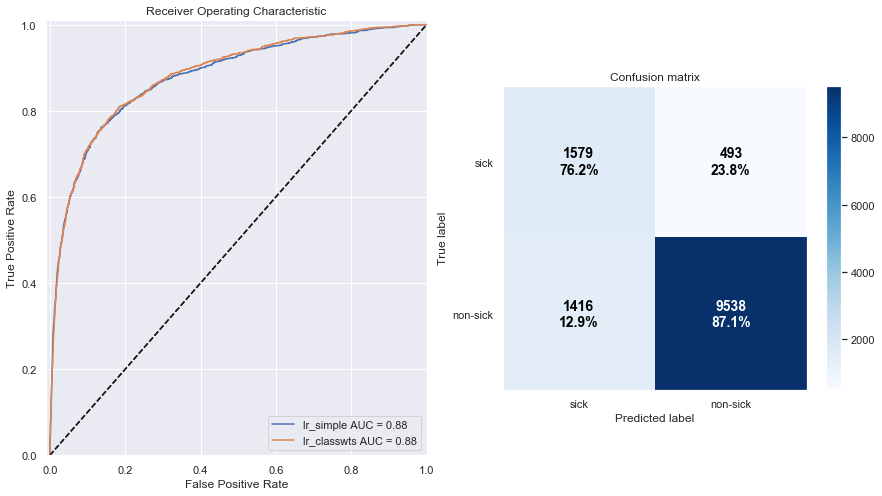

Model Scores
Actual sick rate: 15.91%
Predicted sick rate: 22.99%


,lr_sample,lr_classwts
accuracy,0.902705,0.857329
recall,0.475401,0.741496
precision,0.740278,0.495377
f1,0.578983,0.593950
roc_auc,0.880678,0.880678
cross_entropy,0.263307,0.263307
cohen_kappa,0.542994,0.535996


In [12]:
# Show plot of metrics
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,8))
plot_roc(y_test, y_pred, y_prob, "lr_simple", ax= axes[0], sample_weights= w_test)
plot_roc(y_test, y_pred_w, y_prob_w, "lr_classwts", ax= axes[0], sample_weights= w_test)
plot_confusion_matrix(y_test, y_pred_w, ax= axes[1])
plt.show()
get_metrics(y_test, y_pred_w, 'lr_classwts', sample_weights = w_test)

This did not change the AUC much, but it made a significant improvement to the model's recall, bringing it up to about 74%. However, the precision decreased. The f1 score (a function of Precision and Recall) is slightly better with the classwts.

## Oversampling and Undersampling <a class="anchor" id="over-and-under-sampling">
    
Another method is to resample the dataset so the classes are balanced. This can be done by either [oversampling or undersampling](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis). With oversampling, we randomly replicate samples of the under-represented class. This is typically the preferred method when the dataset is rather small, on the order of a few thousand records. Undersampling reduces the size of the dataset by sampling the over-represented class. This is a prefereable method when the dataset is very large, since reducing the size of the training set can also reduce the computational cost.

The African dataset contains about 39,000 records, with only 16% being in the 'sick' class. If we use undersampling, this will reduce our training set to ~12,500 records. If we use oversampling, we will increase the size of the dataset to about 65,500 records. We will try both approaches here and see which offers better performance.

Fortunately, there is a Python package called [imbalanced-learn](https://github.com/scikit-learn-contrib/imbalanced-learn) that provides implementations of several popular oversampling and undersampling techniques and is compatible with scikit-learn.

### Oversampling <a class="anchor" id="oversampling">
One of the most popular oversampling methods is called SMOTE, or [Synthetic Minority Oversampling Technique](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/). This works by creating synthetic samples of the under-represented class by finding nearest neighbors and making minor random perturbations.     
    

In [13]:
from imblearn.over_sampling import SMOTE

# Apply oversampling with SMOTE
X_train_o, y_train_o = SMOTE().fit_sample(X_train, y_train)
print("X shape after oversampling: ", X_train_o.shape)

# Fit the model
model = LogisticRegression()
%time model.fit(X_train_o, y_train_o)

# Get an initial score
%time score = model.score(X_train_o, y_train_o)
print("In-sample score: {:0.2%}".format(score))

# Store coefficients
coefs = get_coefs_df(X_train_o, model.coef_[0])

# Run the model
y_pred_o = model.predict(X_test)
y_prob_o = model.predict_proba(X_test)[:,1]

Using TensorFlow backend.


X shape after oversampling:  (65720, 236)


/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


CPU times: user 1.45 s, sys: 21.2 ms, total: 1.47 s
Wall time: 1.47 s
CPU times: user 38.6 ms, sys: 54.2 ms, total: 92.8 ms
Wall time: 19.3 ms
In-sample score: 82.53%


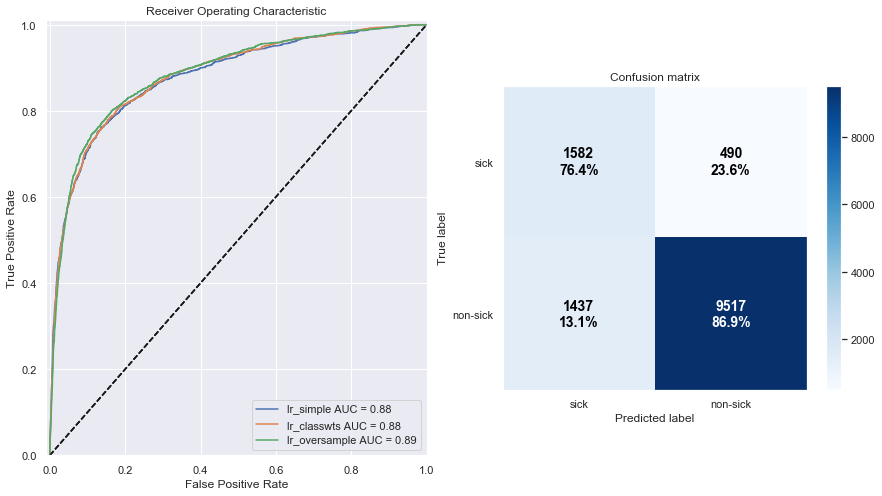

Model Scores
Actual sick rate: 15.91%
Predicted sick rate: 23.18%


,lr_sample,lr_classwts,lr_oversample
accuracy,0.902705,0.857329,0.852065
recall,0.475401,0.741496,0.763514
precision,0.740278,0.495377,0.524015
f1,0.578983,0.593950,0.621489
roc_auc,0.880678,0.880678,0.883381
cross_entropy,0.263307,0.263307,0.279932
cohen_kappa,0.542994,0.535996,0.533477


In [14]:
# Show plot of metrics
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,8))
plot_roc(y_test, y_pred, y_prob, "lr_simple", ax= axes[0], sample_weights= w_test)
plot_roc(y_test, y_pred_w, y_prob_w, "lr_classwts", ax= axes[0], sample_weights= w_test)
plot_roc(y_test, y_pred_o, y_prob_o, "lr_oversample", ax= axes[0])
plot_confusion_matrix(y_test, y_pred_o, ax= axes[1])
plt.show()
get_metrics(y_test, y_pred_o, 'lr_oversample')

We can see that oversampling is better than the class weighting for all metrics. But it still lack of precision with only 52%.

### Undersampling <a class="anchor" id="undersampling">
Next, we'll apply undersampling using the `RandomUnderSampler` function from imbalanced-learn. This randomly takes samples the majority class to match the number of records from the under-represented class (or to reach a desired class ratio).

In [15]:
from imblearn.under_sampling import RandomUnderSampler

# Apply random undersampling
X_train_u, y_train_u = RandomUnderSampler().fit_sample(X_train, y_train)
print("X shape after undersampling: ", X_train_u.shape)

# Fit the model
model = LogisticRegression()
%time model.fit(X_train_u, y_train_u)

# Get an initial score
%time score = model.score(X_train_u, y_train_u)
print("In-sample score: {:0.2%}".format(score))

# Store coefficients
coefs = get_coefs_df(X_train_u, model.coef_[0])

# Run the model
y_pred_u = model.predict(X_test)
y_prob_u = model.predict_proba(X_test)[:,1]

X shape after undersampling:  (12430, 236)
CPU times: user 366 ms, sys: 210 ms, total: 577 ms
Wall time: 191 ms
CPU times: user 5.03 ms, sys: 3.01 ms, total: 8.03 ms
Wall time: 2.23 ms
In-sample score: 82.12%


/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


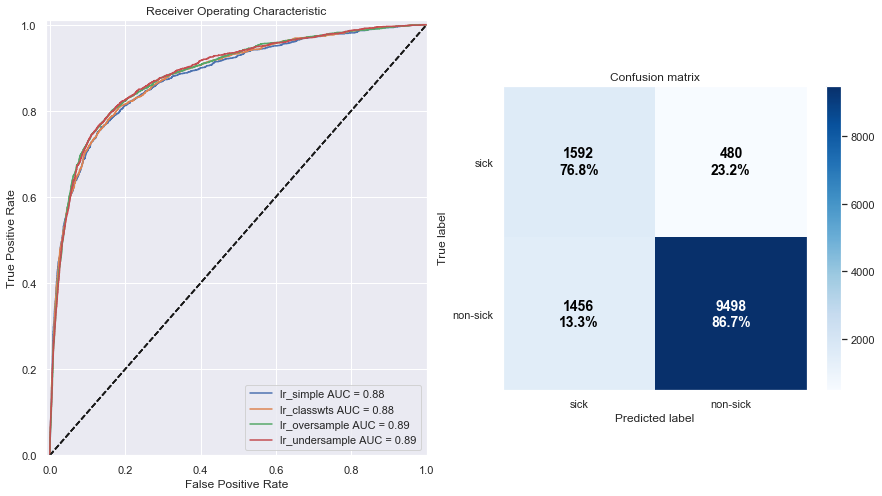

Model Scores
Actual sick rate: 15.91%
Predicted sick rate: 23.40%


,lr_sample,lr_classwts,lr_oversample,lr_undersample
accuracy,0.902705,0.857329,0.852065,0.851374
recall,0.475401,0.741496,0.763514,0.768340
precision,0.740278,0.495377,0.524015,0.522310
f1,0.578983,0.593950,0.621489,0.621875
roc_auc,0.880678,0.880678,0.883381,0.883381
cross_entropy,0.263307,0.263307,0.279932,0.279932
cohen_kappa,0.542994,0.535996,0.533477,0.533531


In [16]:
# Show plot of metrics
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,8))
plot_roc(y_test, y_pred, y_prob, "lr_simple", ax= axes[0], sample_weights= w_test)
plot_roc(y_test, y_pred_w, y_prob_w, "lr_classwts", ax= axes[0], sample_weights= w_test)
plot_roc(y_test, y_pred_o, y_prob_o, "lr_oversample", ax= axes[0])
plot_roc(y_test, y_pred_u, y_prob_u, "lr_undersample", ax= axes[0])
plot_confusion_matrix(y_test, y_pred_u, ax= axes[1])
plt.show()
get_metrics(y_test, y_pred_u, 'lr_undersample')

The oversample method gives slightly better accuracy than using the undersampling. The recall is a bit worse than the undersample, and we want to have a good recall, that is, predict "sick" when the individual is really "sick". As the f1 very similar with both method, and undersampling also has better recall we will use this method going forward.

# Cross Validation and Parameter Tuning <a class="anchor" id="cv-param-tuning"></a>

One common method is to use [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics%29) when fitting the model. Cross-validation divides the training set into a number of different "folds" and fits the model to each. Scikit-Learn includes a variation on the LogisticRegression model that implements cross-validation, called [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). This function utilized stratified k-folds, which means each fold of data contains the same proportion of the response variable in each fold.

## Parameter Tuning
We can also improve model performance by searching for the best parameters. The Scikit-learn LogisticRegression model applies 'l2' [regularization](https://en.wikipedia.org/wiki/Regularization_(mathematics%29) by default. The regularization term includes a 'C' parameter that allows us to specify the strength of the regularization, with a smaller 'C' meaning stronger regularization. We can attempt to improve our model results by tuning this parameter.

Let's build the model again using LogisticRegression, with 5 cross-validation folds and 10 values of C from 1e-4 to 1e4.

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Create pipeline
pipe = Pipeline([
    ('logreg', LogisticRegression())
])

# Create cross-validation object
grid = {
    'logreg__C': np.logspace(-4, 4, num=10)
}

model = GridSearchCV(pipe, grid, cv=5, return_train_score=True, verbose=1)

# Fit the model using the undersampling method
%time model.fit(X_train_u, y_train_u)

# Get an initial score
%time score = model.score(X_train_u, y_train_u)
print("In-sample score: {:0.2%}".format(score))
print("Best model parameters:", model.best_params_)

# Run the model
y_pred_cv = model.predict(X_test)
y_prob_cv = model.predict_proba(X_test)[:,1]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver t

CPU times: user 14.4 s, sys: 28.8 s, total: 43.2 s
Wall time: 8.99 s
CPU times: user 4.62 ms, sys: 5.49 ms, total: 10.1 ms
Wall time: 1.99 ms
In-sample score: 82.16%


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    8.9s finished
/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


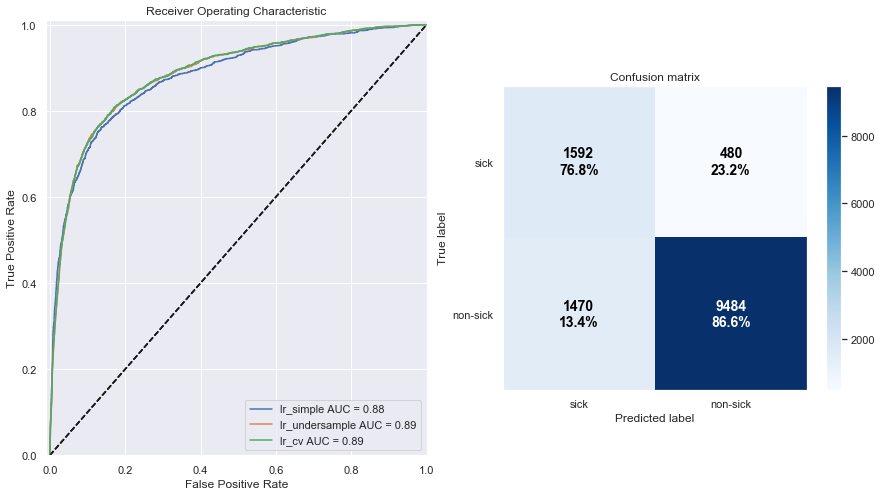

Model Scores
Actual sick rate: 15.91%
Predicted sick rate: 23.51%


,lr_sample,lr_classwts,lr_oversample,lr_undersample,lr_cv
accuracy,0.902705,0.857329,0.852065,0.851374,0.850299
recall,0.475401,0.741496,0.763514,0.768340,0.768340
precision,0.740278,0.495377,0.524015,0.522310,0.519922
f1,0.578983,0.593950,0.621489,0.621875,0.620179
roc_auc,0.880678,0.880678,0.883381,0.883381,0.883381
cross_entropy,0.263307,0.263307,0.279932,0.279932,0.279932
cohen_kappa,0.542994,0.535996,0.533477,0.533531,0.531236


In [33]:
# Show plot of metrics
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,8))
plot_roc(y_test, y_pred, y_prob, "lr_simple", ax= axes[0], sample_weights= w_test)
plot_roc(y_test, y_pred_u, y_prob_u, "lr_undersample", ax= axes[0])
plot_roc(y_test, y_pred_cv, y_prob_cv, "lr_cv", ax= axes[0])
plot_confusion_matrix(y_test, y_pred_cv, ax= axes[1])
plt.show()
get_metrics(y_test, y_pred_cv, 'lr_cv')

Using cross-validation and tuning the C parameter does not appear to have a major effect, but it is also much more computationally expensive to train the model. The precision metric is also still fairly low. We may be able to do better by performing more detailed feature selection and fine tuning the model further, but this serves as a decent baseline model for this project.

Let's see how the accuracy evolves in the train and test set according to the regularization parameter C.

In [35]:
# Collect results in a DataFrame
cv_results = pd.DataFrame(model.cv_results_)

# Print a few interesting columns
cols = ['mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score', 'param_logreg__C']
cv_results[cols].sort_values('mean_test_score', ascending=False)

,mean_test_score,std_test_score,mean_train_score,std_train_score,param_logreg__C
4,0.813113,0.004469,0.822405,0.001713,0.359381
6,0.812550,0.004006,0.824296,0.001245,21.5443
5,0.812228,0.004275,0.824256,0.001214,2.78256
7,0.812148,0.004479,0.824276,0.001356,166.81
8,0.812148,0.004479,0.824276,0.001386,1291.55
9,0.812148,0.004479,0.824276,0.001386,10000
3,0.810378,0.005871,0.816573,0.002029,0.0464159
2,0.793484,0.005364,0.798632,0.000806,0.00599484
1,0.774014,0.008107,0.776267,0.001338,0.000774264
0,0.758970,0.009655,0.759352,0.002086,0.0001


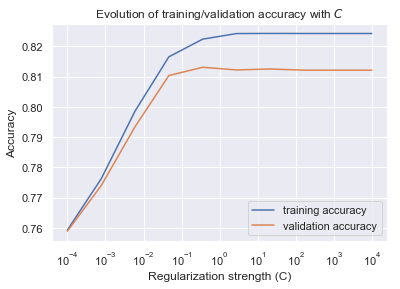

In [36]:
# Plot training/validation accuracy curves
plt.semilogx(cv_results["param_logreg__C"], cv_results["mean_train_score"], label='training accuracy')
plt.semilogx(cv_results["param_logreg__C"], cv_results["mean_test_score"],  label='validation accuracy')
plt.xlabel('Regularization strength (C)')
plt.ylabel('Accuracy')
plt.title("Evolution of training/validation accuracy with $C$")
plt.legend()
plt.show()

We see that the train set stagnates from an accuracy of 82%, proof that the model is not overfitting. We notice that a parameter C (weight of the loss function) improves the accuracy until about 0.1, then stagnates.

# Feature selection <a class="anchor" id="feature-selection"></a>

Can we do even better using a Logistic Regression Classifier? Using the full survey data, we had a model with *236* features, and the accuracy went up from 84% to about 85%, but at what cost? 

Conducting the full surveys takes a significant amount of time and resources for each household. If we could get similar results using much fewer features, it would be more cost and time efficient, and we could actually collect more data by conducting more surveys, which would possibly enable us to train the model for even higher accuracy.

Let's take a deeper look at the features and see if we can improve the model by using a better subset of features and tuning the parameters. 

## Feature Selection using l1 regularization

We mentioned earlier that the LogisticRegression model applies 'l2' regularization by default. If we apply 'l1' regularization instead, many of the estimated coefficients go to zero. We can select a 'C' value that will set most of the coefficients to zero and use this to reduce the number of features for the model. 

To demonstrate, we'll set $ C=5e-2 $ and see which features remain.

In [18]:
# Retrieve column names
cols = X_train.columns

# Fit the model
model = LogisticRegressionCV(cv=5, penalty='l1', Cs=[7e-2] , solver='liblinear')
%time model.fit(X_train_u, y_train_u)
coefs = get_coefs_df(X_train_u, model.coef_[0])
coefs = coefs.set_index(cols)
coefs = coefs[coefs.coef != 0]

print("{} features selected".format(coefs.shape[0]))
display(coefs)
feats = coefs.index.values

CPU times: user 768 ms, sys: 1.67 s, total: 2.44 s
Wall time: 435 ms
109 features selected


,coef_std,coef,abs
Q14AGE,0.808804,0.728208,0.808804
Q613BED,0.524352,1.315666,0.524352
Q615KITCHEN,0.362703,1.744207,0.362703
Q616BATH,0.351568,1.817383,0.351568
Q617TOILET,0.318209,1.136422,0.318209
Q161APUBATT,0.317595,0.749319,0.317595
Q161APRIVATT,0.250808,1.826395,0.250808
hhsize,0.221592,0.528771,0.221592
expenditure_pcp,0.209915,1.450560,0.209915
pcnetincome,0.205896,1.493232,0.205896


Now let's see how the model performs with this subset of features.

In [19]:
# Load and transform the training data
X_train_sub = X_train[feats]
X_test_sub = X_test[feats]
cols = X_train_sub.columns


# Apply random oversampling
X_train_u_sub, y_train_u_sub = RandomUnderSampler().fit_sample(X_train_sub, y_train)
print("X shape after undersampling: ", X_train_u_sub.shape)

# Fit the model
model = LogisticRegressionCV(Cs=10, cv=5, verbose=1)
%time model.fit(X_train_u_sub, y_train_u_sub)

# Get an initial score
%time score = model.score(X_train_u_sub, y_train_u_sub)
print("In-sample score: {:0.2%}".format(score))
coefs = get_coefs_df(X_train_u_sub, model.coef_[0])

# Display best parameters
print("Best model parameters: C={}".format(model.C_[0]))

# Run the model
y_pred_sub = model.predict(X_test_sub)
y_prob_sub = model.predict_proba(X_test_sub)[:,1]

X shape after undersampling:  (12430, 109)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iteration

CPU times: user 16.8 s, sys: 19.3 s, total: 36.1 s
Wall time: 4.88 s
CPU times: user 2.35 ms, sys: 4.83 ms, total: 7.18 ms
Wall time: 1.35 ms
In-sample score: 81.84%
Best model parameters: C=2.782559402207126


/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


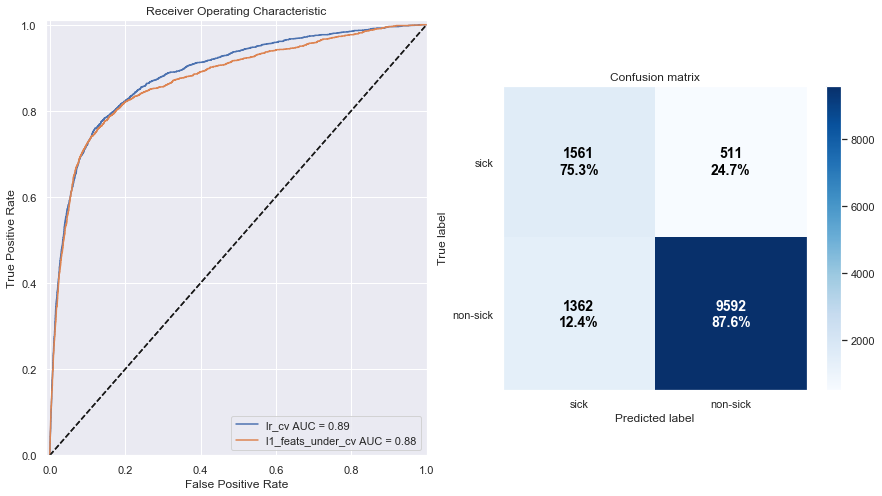

Model Scores
Actual sick rate: 15.91%
Predicted sick rate: 22.44%


,l1_feats_under_cv,lr_cv
accuracy,0.856211,0.850683
recall,0.753378,0.769788
precision,0.534040,0.520731
f1,0.625025,0.621227
roc_auc,0.883381,0.883381
cross_entropy,0.279932,0.279932
cohen_kappa,0.539248,0.532515


In [20]:
# Show plot of metrics
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,8))
plot_roc(y_test, y_pred_cv, y_prob_cv, "lr_cv", ax= axes[0])
plot_roc(y_test, y_pred_sub, y_prob_sub, "l1_feats_under_cv", ax= axes[0])
plot_confusion_matrix(y_test, y_pred_sub, ax= axes[1])
plt.show()
get_metrics(y_test, y_pred_sub, 'l1_feats_under_cv')
model_score[['l1_feats_under_cv', 'lr_cv']]

Using this method, we get slightly better performance than the full feature model, and we have reduced the number of features to less than 100.

# Logistic Regression Summary <a class="anchor" id="summary"></a>

In this notebook, we applied a logistic regression classifier to an unbalanced data. To evaluate which model is the best, I will simply calculate the mean of all the metrics. The model that has the higher value of mean metrics will be chosen. As cross-entropy, unlike any other metrics, is better, the lower the value, I will calculate (1 -  cross-entropy) for the mean.

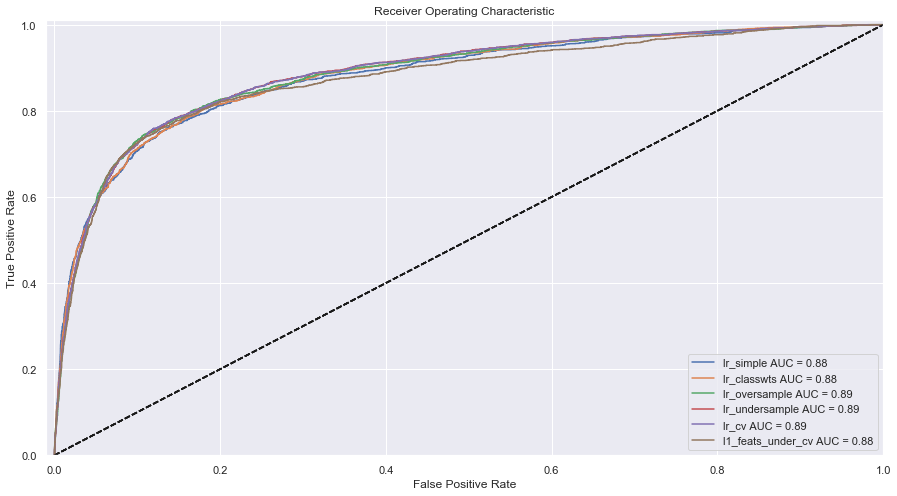

Model Scores
Actual sick rate: 15.91%
Predicted sick rate: 22.44%


,lr_sample,lr_classwts,lr_oversample,lr_undersample,lr_cv,l1_feats_under_cv
accuracy,0.902705,0.857329,0.853370,0.850683,0.850683,0.856211
recall,0.475401,0.741496,0.765444,0.769305,0.769788,0.753378
precision,0.740278,0.495377,0.526910,0.520745,0.520731,0.534040
f1,0.578983,0.593950,0.624164,0.621079,0.621227,0.625025
roc_auc,0.880678,0.880678,0.883381,0.883381,0.883381,0.883381
cross_entropy,0.263307,0.263307,0.279932,0.279932,0.279932,0.279932
cohen_kappa,0.542994,0.535996,0.536905,0.532361,0.532515,0.539248


In [21]:
# Show plot of metrics
fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (15,8))
plot_roc(y_test, y_pred, y_prob, "lr_simple", ax= axes, sample_weights= w_test)
plot_roc(y_test, y_pred_w, y_prob_w, "lr_classwts", ax= axes, sample_weights= w_test)
plot_roc(y_test, y_pred_o, y_prob_o, "lr_oversample", ax= axes)
plot_roc(y_test, y_pred_u, y_prob_u, "lr_undersample", ax= axes)
plot_roc(y_test, y_pred_cv, y_prob_cv, "lr_cv", ax= axes)
plot_roc(y_test, y_pred_sub, y_prob_sub, "l1_feats_under_cv", ax= axes)
plt.show()
get_metrics(y_test, y_pred_sub, 'l1_feats_under_cv')

In [22]:
# Inverse the cross entropy values
model_eval = model_score.copy()
model_eval[model_eval.index == 'cross_entropy'] = 1 - model_eval[model_eval.index == 'cross_entropy']

model_eval.mean().sort_values(ascending = False)

l1_feats_under_cv    0.701622
lr_oversample        0.701463
lr_cv                0.699770
lr_undersample       0.699660
lr_sample            0.693962
lr_classwts          0.691646
dtype: float64